In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

TRADING_DAYS = 252
ROLL_3M = 63
ROLL_1Y = 252

REBAL_FEE_PCT = 0.003
REBAL_FEE_RATE = REBAL_FEE_PCT / 100.0

EQUITY_PROXY_CANDIDATES = ["SPY", "^SPX", "URTH", "^RUT"]

# Traditional universe used for correlations/plots
TRAD_CANDIDATES = [
    "^SPX", "^RUT", "URTH",
    "AGG", "IEF", "TLT",
    "VNQ",
    "GLD", "DBC",
    "PUT", "^VIX",
    "^IRX",         # rate level
    "CDX.NA.IG"     # spread/risk proxy
]

FF_COLS = ["Mkt-RF", "SMB", "HML", "RF"]


def ensure_dirs():
    """Make output folders."""
    os.makedirs(FIG_DIR, exist_ok=True)
    os.makedirs(TABLE_DIR, exist_ok=True)


def read_master_csv(path: str) -> pd.DataFrame:
    """Read master CSV and parse DATE index"""
    df = pd.read_csv(path)

    if "DATE" not in df.columns:
        df.rename(columns={df.columns[0]: "DATE"}, inplace=True)

    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    bad = df["DATE"].isna().mean()
    if bad > 0.2:
        df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y", errors="coerce")

    df = df.dropna(subset=["DATE"]).set_index("DATE").sort_index()

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def first_available(df: pd.DataFrame, candidates: list[str]) -> str:
    """Pick first existing column name"""
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns exist: {candidates}")


def price_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """Simple returns from price levels"""
    return prices.pct_change()


def to_decimal_ff(ff: pd.DataFrame) -> pd.DataFrame:
    """FF daily factors are in percent; convert to decimal"""
    return ff / 100.0


def cum_growth(r: pd.Series) -> pd.Series:
    """$1 growth curve."""
    return (1.0 + r.fillna(0.0)).cumprod()


def drawdown_curve(r: pd.Series) -> pd.Series:
    """Drawdown from running peak"""
    g = cum_growth(r)
    peak = g.cummax()
    return g / peak - 1.0


def cagr(r: pd.Series) -> float:
    """CAGR using actual calendar time"""
    r = r.dropna()
    if r.empty:
        return np.nan
    total = (1 + r).prod()
    years = (r.index[-1] - r.index[0]).days / 365.25
    return total ** (1 / years) - 1 if years > 0 else np.nan


def ann_vol(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    """Annualized vol"""
    return r.dropna().std(ddof=1) * np.sqrt(freq)


def sharpe(r: pd.Series, rf_daily: pd.Series) -> float:
    """Annualized Sharpe vs daily rf"""
    x = (r - rf_daily).dropna()
    if x.std(ddof=1) == 0 or x.empty:
        return np.nan
    return (x.mean() / x.std(ddof=1)) * np.sqrt(TRADING_DAYS)


def downside_dev(excess: pd.Series) -> float:
    """Annualized downside deviation"""
    d = excess.copy()
    d[d > 0] = 0
    if d.dropna().empty:
        return np.nan
    return np.sqrt((d**2).mean()) * np.sqrt(TRADING_DAYS)


def sortino(r: pd.Series, rf_daily: pd.Series) -> float:
    """Annualized Sortino vs daily rf"""
    ex = (r - rf_daily).dropna()
    dd = downside_dev(ex)
    if dd == 0 or np.isnan(dd) or ex.empty:
        return np.nan
    return ex.mean() * TRADING_DAYS / dd


def max_drawdown(r: pd.Series) -> float:
    """Max drawdown"""
    return drawdown_curve(r).min()


def calmar(r: pd.Series) -> float:
    """CAGR / |MaxDD|"""
    md = abs(max_drawdown(r))
    return cagr(r) / md if md > 0 else np.nan


def win_rate(r: pd.Series) -> float:
    """Share of positive return days."""
    r = r.dropna()
    return (r > 0).mean() if not r.empty else np.nan


def perf_table(returns: pd.DataFrame, rf_daily: pd.Series) -> pd.DataFrame:
    """Metrics table for many return series."""
    out = []
    for c in returns.columns:
        r = returns[c].dropna()
        if r.empty:
            continue
        out.append({
            "Series": c,
            "CAGR": cagr(r),
            "AnnVol": ann_vol(r),
            "Sharpe": sharpe(r, rf_daily),
            "Sortino": sortino(r, rf_daily),
            "MaxDD": max_drawdown(r),
            "Calmar": calmar(r),
            "WinRate": win_rate(r),
            "Skew": r.skew(),
            "Kurt": r.kurtosis()
        })
    df = pd.DataFrame(out).set_index("Series").sort_values("Sharpe", ascending=False)
    return df


def normalize_weights(w: dict) -> pd.Series:
    """Weights -> Series, sums to 1."""
    s = pd.Series(w, dtype=float)
    s = s[s != 0].dropna()
    s = s / s.sum()
    return s


def filter_weights_to_available(weights: pd.Series, available_cols: list[str]) -> pd.Series:
    """Drop missing assets and renormalize."""
    w = weights[weights.index.isin(available_cols)].copy()
    if w.empty:
        raise KeyError("None of the assets in this portfolio exist in the dataset.")
    return w / w.sum()


def simulate_buy_and_hold(prices: pd.DataFrame, weights: pd.Series, initial_value: float = 1.0):
    """Buy-and-hold, no rebalancing"""
    # Start on first date
    px = prices[weights.index].dropna()
    start_px = px.iloc[0]

    # Shares fixed for fully buy-and-hold
    holdings = (initial_value * weights) / start_px
    value = (px * holdings).sum(axis=1)
    ret = value.pct_change()

    # Weight drift 
    drift_w = (px * holdings).div(value, axis=0)

    return value, ret, drift_w



def simulate_rebalanced(
    prices: pd.DataFrame,
    weights: pd.Series,
    rebalance: str = "M",
    initial_value: float = 1.0,
    fee_rate: float = 0.0
):
    """Periodic rebalancing (with optional trading fee)."""
    px = prices[weights.index].dropna()

    # Rebalance on first trading day of each period
    grp = px.index.to_period(rebalance)
    rebalance_dates = px.groupby(grp).head(1).index
    rebalance_dates = pd.Index(rebalance_dates)

    value = pd.Series(index=px.index, dtype=float)
    drift_w = pd.DataFrame(index=px.index, columns=weights.index, dtype=float)

    # Diagnostics
    tcost = pd.Series(index=px.index, dtype=float)
    turnover = pd.Series(index=px.index, dtype=float)

    v = float(initial_value)
    holdings = (v * weights) / px.iloc[0]

    for dt, row in px.iterrows():
        current_values = row * holdings
        v_pre = float(current_values.sum())

        if dt in rebalance_dates and dt != px.index[0]:
            target_values = v_pre * weights
            traded_notional = (target_values - current_values).abs().sum()

            fee = float(traded_notional * fee_rate)
            v_post = v_pre - fee

            holdings = (v_post * weights) / row

            value.loc[dt] = v_post
            drift_w.loc[dt] = weights

            tcost.loc[dt] = fee
            turnover.loc[dt] = traded_notional / v_pre if v_pre > 0 else np.nan
        else:
            value.loc[dt] = v_pre
            drift_w.loc[dt] = (current_values / v_pre) if v_pre > 0 else np.nan

    ret = value.pct_change()
    return value, ret, drift_w, tcost, turnover

def rolling_stats(r: pd.Series, rf_daily: pd.Series, window: int = ROLL_1Y) -> pd.DataFrame:
    """Rolling vol + Sharpe."""
    x = (r - rf_daily).dropna()
    out = pd.DataFrame(index=x.index)
    out["RollVol"] = x.rolling(window).std(ddof=1) * np.sqrt(TRADING_DAYS)
    out["RollSharpe"] = (x.rolling(window).mean() / x.rolling(window).std(ddof=1)) * np.sqrt(TRADING_DAYS)
    return out


def plot_and_save(fig, name: str):
    """Save and show a plot."""
    path = os.path.join(FIG_DIR, f"{name}.png")
    fig.tight_layout()
    fig.savefig(path, dpi=160)
    plt.show()


def corr_heatmap(df: pd.DataFrame, title: str, fname: str):
    """Correlation heatmap (matplotlib only)."""
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_title(title)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=60, ha="right")
    ax.set_yticklabels(corr.columns)

    # Values
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

    fig.colorbar(im, ax=ax, shrink=0.85)
    plot_and_save(fig, fname)


def ff_regression(excess_r: pd.Series, ff: pd.DataFrame):
    """OLS: excess return ~ Mkt-RF + SMB + HML."""
    # Align and drop NA
    df = pd.concat([excess_r.rename("y"), ff[["Mkt-RF", "SMB", "HML"]]], axis=1).dropna()
    y = df["y"]
    X = sm.add_constant(df[["Mkt-RF", "SMB", "HML"]])

    # HAC helps a bit for daily data
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    return model


def rolling_ff_betas(excess_r: pd.Series, ff: pd.DataFrame, window: int = ROLL_1Y) -> pd.DataFrame:
    """Rolling FF betas (slow but manageable)."""
    df = pd.concat([excess_r.rename("y"), ff[["Mkt-RF", "SMB", "HML"]]], axis=1).dropna()
    betas = []

    idx = df.index
    for i in range(window, len(df) + 1):
        d = df.iloc[i - window:i]
        y = d["y"]
        X = sm.add_constant(d[["Mkt-RF", "SMB", "HML"]])
        fit = sm.OLS(y, X).fit()
        betas.append((idx[i - 1], fit.params.get("Mkt-RF", np.nan), fit.params.get("SMB", np.nan), fit.params.get("HML", np.nan)))

    out = pd.DataFrame(betas, columns=["DATE", "beta_mkt", "beta_smb", "beta_hml"]).set_index("DATE")
    return out


def worst_drawdown_windows(r: pd.Series, top_n: int = 5):
    """Find worst drawdown episodes (simple peak->trough scan)."""
    dd = drawdown_curve(r).dropna()
    if dd.empty:
        return []

    # Local peaks are points where drawdown resets to 0
    g = cum_growth(r).dropna()
    peak = g.cummax()
    is_peak = (g == peak)

    # Build episodes from peak to next peak recovery
    episodes = []
    last_peak_date = g.index[0]
    last_peak_val = g.iloc[0]

    for dt in g.index[1:]:
        if is_peak.loc[dt] and g.loc[dt] >= last_peak_val:
            # Episode ends here
            ep = g.loc[last_peak_date:dt]
            if len(ep) > 1:
                # Trough inside episode
                trough_dt = ep.idxmin()
                dd_ep = (ep / ep.cummax() - 1).min()
                episodes.append((last_peak_date, trough_dt, dt, float(dd_ep)))
            last_peak_date = dt
            last_peak_val = g.loc[dt]

    # Rank by drawdown depth
    episodes = sorted(episodes, key=lambda x: x[3])[:top_n]
    return episodes

In [27]:
ensure_dirs()

master = read_master_csv(MASTER_CSV)

In [28]:
# Split prices vs factors vs indicators
present_ff = [c for c in FF_COLS if c in master.columns]
if len(present_ff) < 4:
    raise KeyError(f"Missing FF columns. Found: {present_ff}. Needed: {FF_COLS}")

ff_raw = master[FF_COLS].copy()
ff = to_decimal_ff(ff_raw)
rf_daily = ff["RF"]

# Price-like columns, everything except FF and CDX 
exclude = set(FF_COLS)
prices = master.drop(columns=[c for c in master.columns if c in exclude], errors="ignore").copy()

equity_proxy = first_available(prices, EQUITY_PROXY_CANDIDATES)
print("Equity proxy:", equity_proxy)

Equity proxy: ^SPX


In [29]:
# Computing returns on investable price series
# treating ^IRX and CDX as indicators
indicator_cols = [c for c in ["^IRX", "CDX.NA.IG"] if c in prices.columns]
investable_cols = [c for c in prices.columns if c not in indicator_cols]

rets = price_returns(prices[investable_cols])

# Align all return series to FF 
rets = rets.join(ff, how="inner")
rets = rets.dropna(subset=["RF"])  

# Pull BTC returns too 
btc_col = "BTC-USD" if "BTC-USD" in rets.columns else None
eth_col = "ETH-USD" if "ETH-USD" in rets.columns else None

C:\Users\kylep\AppData\Local\Temp\ipykernel_16872\1016673484.py:72: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.pct_change()


In [30]:
# Buidling benchmark portfolios
port_defs = {
    "Equity_100": {equity_proxy: 1.00},

    "60_40_Equity_AGG": {equity_proxy: 0.60, "AGG": 0.40},

    "70_30_Equity_AGG": {equity_proxy: 0.70, "AGG": 0.30},

    "60_30_10_Equity_AGG_REIT": {equity_proxy: 0.60, "AGG": 0.30, "VNQ": 0.10},

    "Diversified_40_30_10_10_10": {
        equity_proxy: 0.40, "AGG": 0.30, "VNQ": 0.10, "GLD": 0.10, "DBC": 0.10
    },

    # risk-off alt
    "Treasury_Barbell_IEF_TLT": {"IEF": 0.50, "TLT": 0.50},

    # PutWrite index as an equity-derivatives benchmark
    "PutWrite_100": {"PUT": 1.00},

    "AllWeather_like": {
        equity_proxy: 0.30, "IEF": 0.15, "TLT": 0.25, "VNQ": 0.15, "GLD": 0.075, "DBC": 0.075
    },
}

# only use portfolios where all tickers exist 
available = list(prices.columns)
final_port_defs = {}
for name, w in port_defs.items():
    ws = normalize_weights(w)
    try:
        ws2 = filter_weights_to_available(ws, available)
        final_port_defs[name] = ws2.to_dict()
    except Exception as e:
        print(f"Skipping {name}: {e}")

print("\nPortfolios used:")
for k, v in final_port_defs.items():
    print(f"  - {k}: {v}")


Portfolios used:
  - Equity_100: {'^SPX': 1.0}
  - 60_40_Equity_AGG: {'^SPX': 0.6, 'AGG': 0.4}
  - 70_30_Equity_AGG: {'^SPX': 0.7, 'AGG': 0.3}
  - 60_30_10_Equity_AGG_REIT: {'^SPX': 0.6, 'AGG': 0.3, 'VNQ': 0.09999999999999999}
  - Diversified_40_30_10_10_10: {'^SPX': 0.39999999999999997, 'AGG': 0.3, 'VNQ': 0.09999999999999999, 'GLD': 0.09999999999999999, 'DBC': 0.09999999999999999}
  - Treasury_Barbell_IEF_TLT: {'IEF': 0.5, 'TLT': 0.5}
  - PutWrite_100: {'PUT': 1.0}
  - AllWeather_like: {'^SPX': 0.3, 'IEF': 0.15, 'TLT': 0.25, 'VNQ': 0.15, 'GLD': 0.075, 'DBC': 0.075}


In [31]:
# simulating buy-and-hold vs monthly rebalanced
portfolio_values_bh = {}
portfolio_rets_bh = {}
portfolio_weights_bh = {}

portfolio_values_m = {}
portfolio_rets_m = {}
portfolio_weights_m = {}

portfolio_cost_m = {}
portfolio_turnover_m = {}

for name, w in final_port_defs.items():
    w = pd.Series(w)

    # Using price levels for simulation
    needed_px = prices[w.index].dropna()

    needed_px = needed_px.loc[needed_px.index.intersection(ff.index)].dropna()
    if needed_px.shape[0] < 50:
        print("Skipping (too short):", name)
        continue

    v_bh, r_bh, drift_bh = simulate_buy_and_hold(needed_px, w)
    portfolio_values_bh[name] = v_bh
    portfolio_rets_bh[name] = r_bh
    portfolio_weights_bh[name] = drift_bh

    v_m, r_m, drift_m, tcost_m, turn_m = simulate_rebalanced(
        needed_px, w, rebalance="M", fee_rate=REBAL_FEE_RATE
    )
    portfolio_values_m[name] = v_m
    portfolio_rets_m[name] = r_m
    portfolio_weights_m[name] = drift_m
    portfolio_cost_m[name] = tcost_m
    portfolio_turnover_m[name] = turn_m


port_rets_bh = pd.DataFrame(portfolio_rets_bh)
port_rets_m = pd.DataFrame(portfolio_rets_m)

port_rets_bh = port_rets_bh.join(rf_daily, how="inner")
port_rets_m = port_rets_m.join(rf_daily, how="inner")

turnover_df = pd.DataFrame(portfolio_turnover_m)
cost_df = pd.DataFrame(portfolio_cost_m)

turnover_df.to_csv(os.path.join(TABLE_DIR, "turnover_monthly_rebalanced.csv"))
cost_df.to_csv(os.path.join(TABLE_DIR, "tcost_monthly_rebalanced.csv"))
               
rf_aligned_bh = port_rets_bh["RF"]
rf_aligned_m = port_rets_m["RF"]

port_rets_bh = port_rets_bh.drop(columns=["RF"])
port_rets_m = port_rets_m.drop(columns=["RF"])

In [32]:
# Performance tables
perf_bh = perf_table(port_rets_bh, rf_aligned_bh)
perf_m = perf_table(port_rets_m, rf_aligned_m)

perf_bh.to_csv(os.path.join(TABLE_DIR, "perf_buy_and_hold.csv"))
perf_m.to_csv(os.path.join(TABLE_DIR, "perf_monthly_rebalanced.csv"))

print("\n=== Buy-and-hold performance (top by Sharpe) ===")
print(perf_bh.head(10).round(4))

print("\n=== Monthly rebalanced performance (top by Sharpe) ===")
print(perf_m.head(10).round(4))


=== Buy-and-hold performance (top by Sharpe) ===
                              CAGR  AnnVol  Sharpe  Sortino   MaxDD  Calmar  \
Series                                                                        
Diversified_40_30_10_10_10  0.0944  0.1137  0.6406   0.8815 -0.2239  0.4217   
Equity_100                  0.1336  0.1872  0.6368   0.8889 -0.3392  0.3938   
70_30_Equity_AGG            0.1080  0.1444  0.6175   0.8588 -0.2587  0.4173   
60_40_Equity_AGG            0.0983  0.1293  0.6055   0.8409 -0.2291  0.4290   
60_30_10_Equity_AGG_REIT    0.1001  0.1418  0.5757   0.7966 -0.2652  0.3773   
AllWeather_like             0.0765  0.1008  0.5454   0.7533 -0.2295  0.3336   
PutWrite_100                0.0778  0.1335  0.4498   0.5944 -0.2893  0.2691   
Treasury_Barbell_IEF_TLT    0.0044  0.1092 -0.1252  -0.1771 -0.3744  0.0117   

                            WinRate    Skew     Kurt  
Series                                                
Diversified_40_30_10_10_10   0.5660 -0.6970  15.9

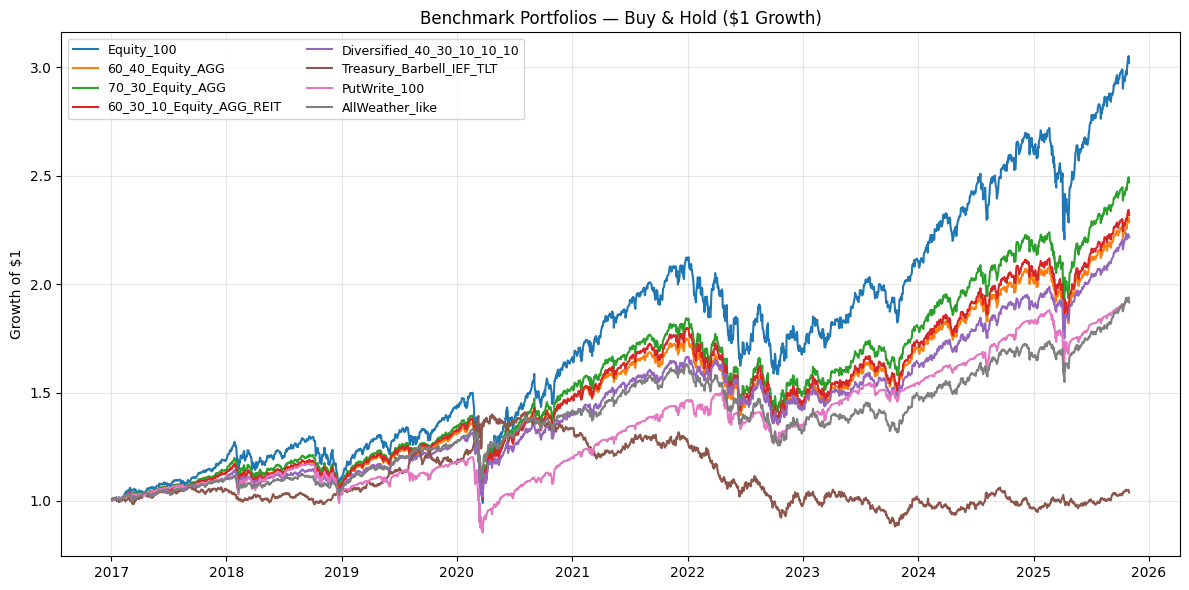

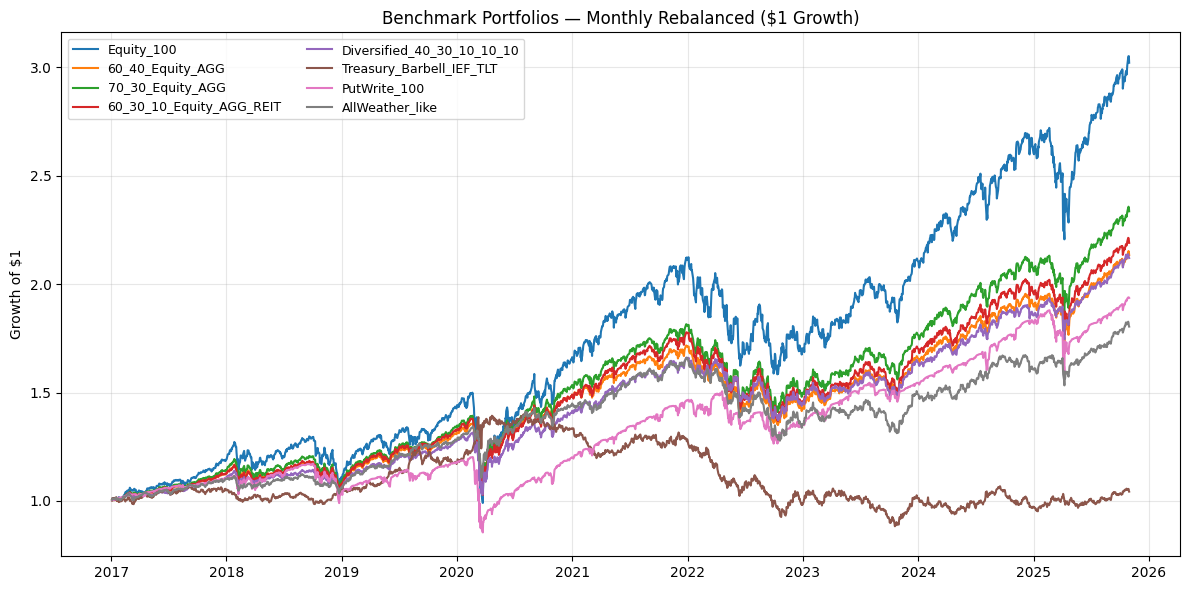

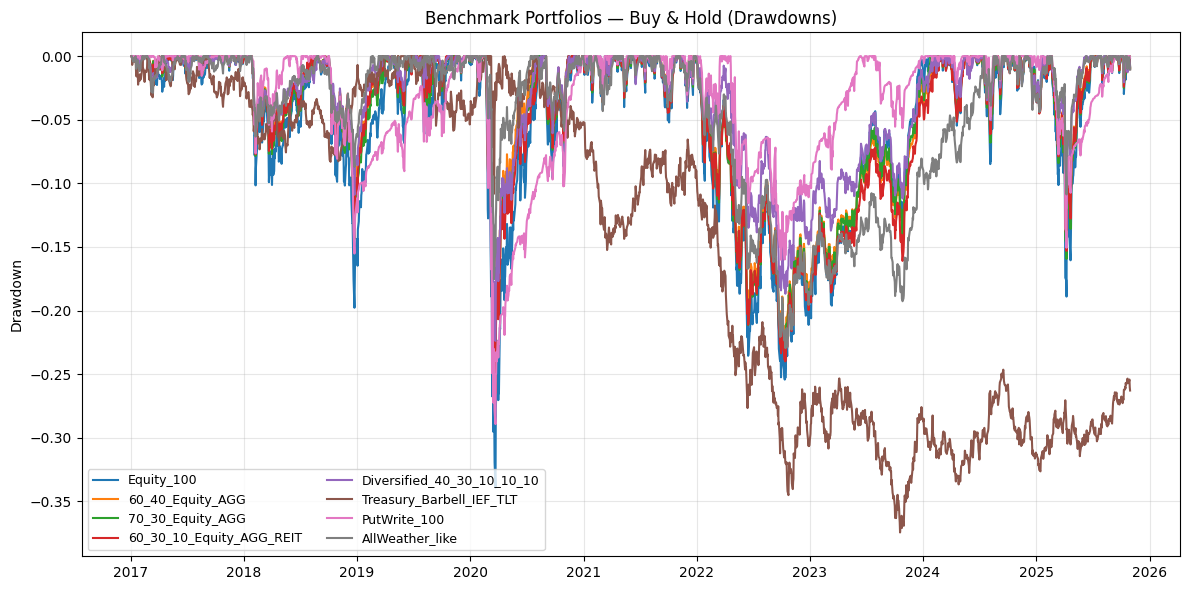

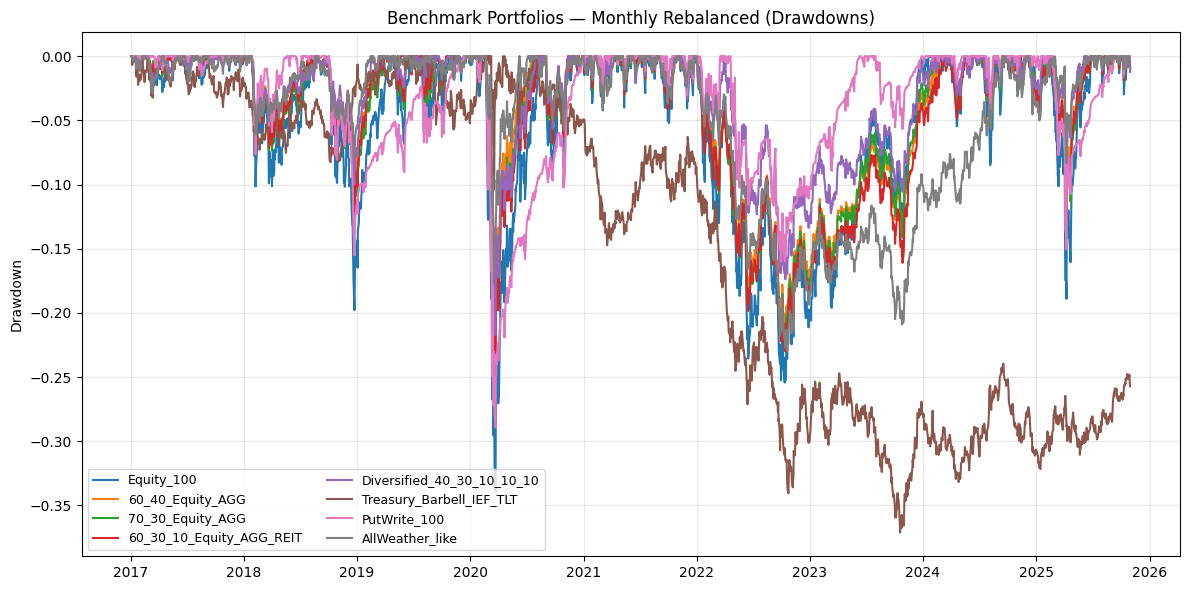

In [33]:
# equity curves & drawdowns
def plot_equity_curves(returns_df: pd.DataFrame, title: str, fname: str):
    """Plot $1 curves for multiple series."""
    fig, ax = plt.subplots(figsize=(12, 6))
    for c in returns_df.columns:
        ax.plot(cum_growth(returns_df[c]), label=c)
    ax.set_title(title)
    ax.set_ylabel("Growth of $1")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plot_and_save(fig, fname)

def plot_drawdowns(returns_df: pd.DataFrame, title: str, fname: str):
    """Plot drawdowns for multiple series."""
    fig, ax = plt.subplots(figsize=(12, 6))
    for c in returns_df.columns:
        ax.plot(drawdown_curve(returns_df[c]), label=c)
    ax.set_title(title)
    ax.set_ylabel("Drawdown")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plot_and_save(fig, fname)

plot_equity_curves(port_rets_bh.dropna(how="all"), "Benchmark Portfolios — Buy & Hold ($1 Growth)", "equity_curves_buyhold")
plot_equity_curves(port_rets_m.dropna(how="all"), "Benchmark Portfolios — Monthly Rebalanced ($1 Growth)", "equity_curves_monthly")

plot_drawdowns(port_rets_bh.dropna(how="all"), "Benchmark Portfolios — Buy & Hold (Drawdowns)", "drawdowns_buyhold")
plot_drawdowns(port_rets_m.dropna(how="all"), "Benchmark Portfolios — Monthly Rebalanced (Drawdowns)", "drawdowns_monthly")

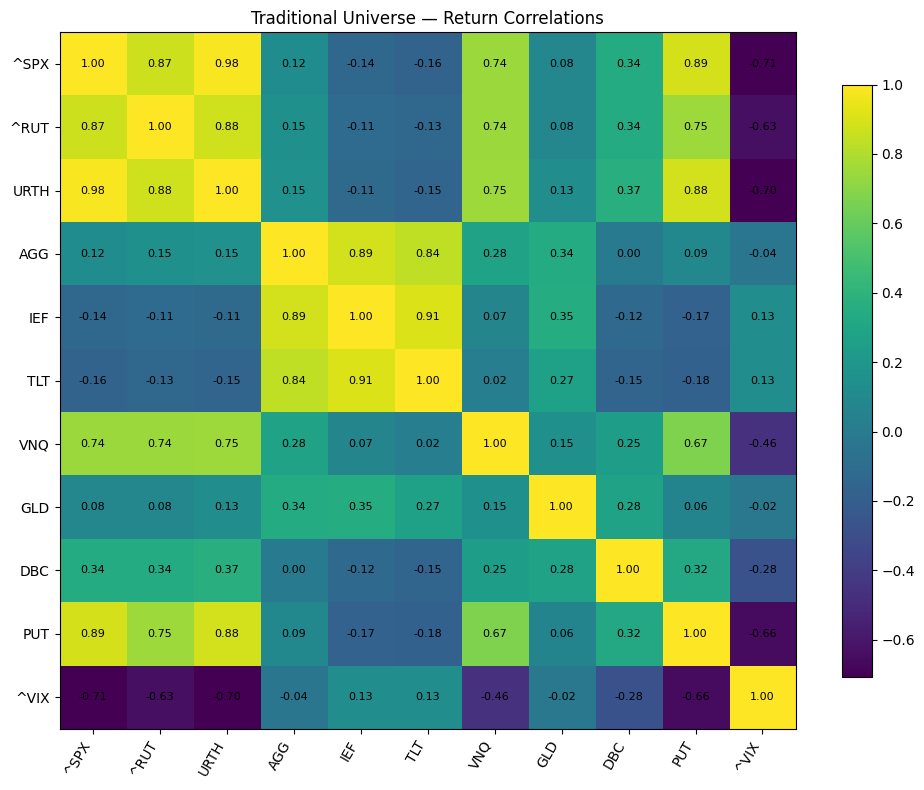

In [34]:
# Traditional asset correlation heatmap of returns 
trad_present = [c for c in TRAD_CANDIDATES if c in rets.columns]
trad_investable = [c for c in trad_present if c not in ["^IRX", "CDX.NA.IG"]]  
corr_src = rets[trad_investable].dropna()
if corr_src.shape[1] >= 4:
    corr_heatmap(corr_src, "Traditional Universe — Return Correlations", "corr_heatmap_traditional")

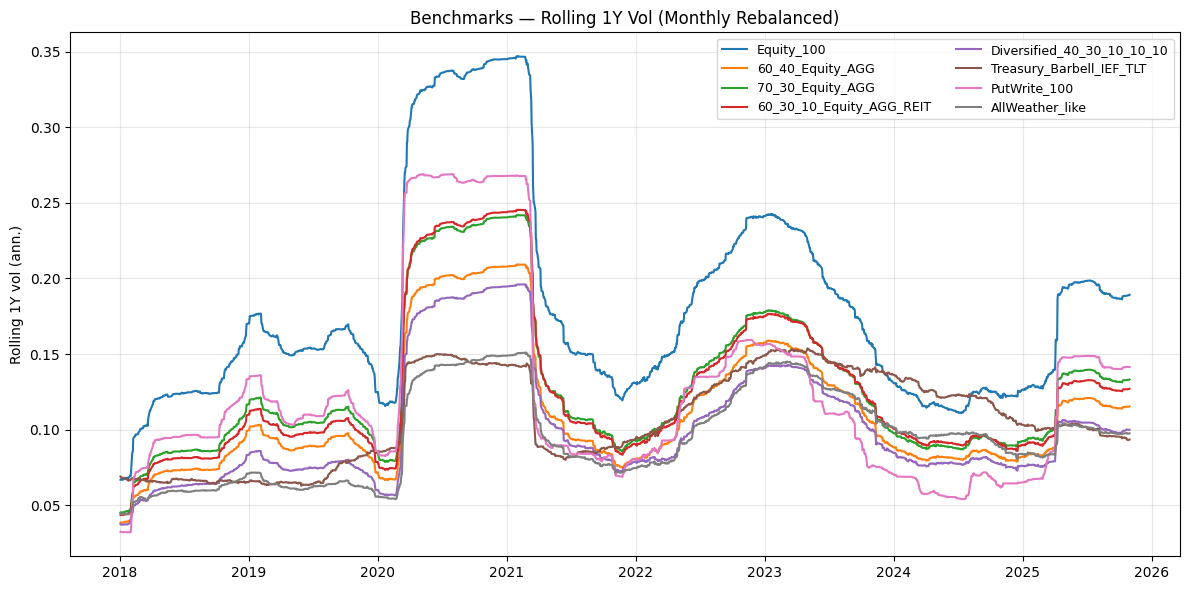

In [35]:
# rolling risk and rolling corr vs BTC
def plot_rolling_vol(returns_df: pd.DataFrame, title: str, fname: str):
    """Rolling 1Y vol for multiple portfolios."""
    fig, ax = plt.subplots(figsize=(12, 6))
    for c in returns_df.columns:
        ax.plot(returns_df[c].rolling(ROLL_1Y).std(ddof=1) * np.sqrt(TRADING_DAYS), label=c)
    ax.set_title(title)
    ax.set_ylabel("Rolling 1Y vol (ann.)")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plot_and_save(fig, fname)

plot_rolling_vol(port_rets_m.dropna(how="all"), "Benchmarks — Rolling 1Y Vol (Monthly Rebalanced)", "rolling_vol_monthly")

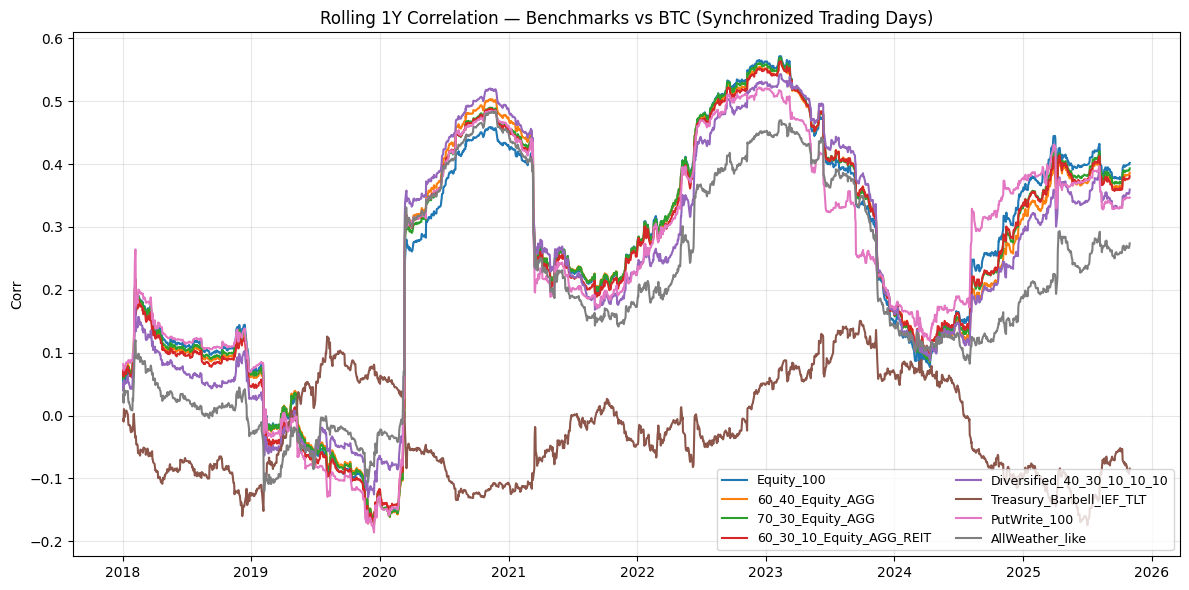

In [36]:
if btc_col:
    btc_r = rets[btc_col].dropna()

    # rolling corr
    fig, ax = plt.subplots(figsize=(12, 6))
    for c in port_rets_m.columns:
        dfc = pd.concat([port_rets_m[c], btc_r], axis=1).dropna()
        if dfc.shape[0] < ROLL_1Y:
            continue
        roll_corr = dfc.iloc[:, 0].rolling(ROLL_1Y).corr(dfc.iloc[:, 1])
        ax.plot(roll_corr, label=c)
    ax.set_title("Rolling 1Y Correlation — Benchmarks vs BTC (Synchronized Trading Days)")
    ax.set_ylabel("Corr")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plot_and_save(fig, "rolling_corr_bench_vs_btc")

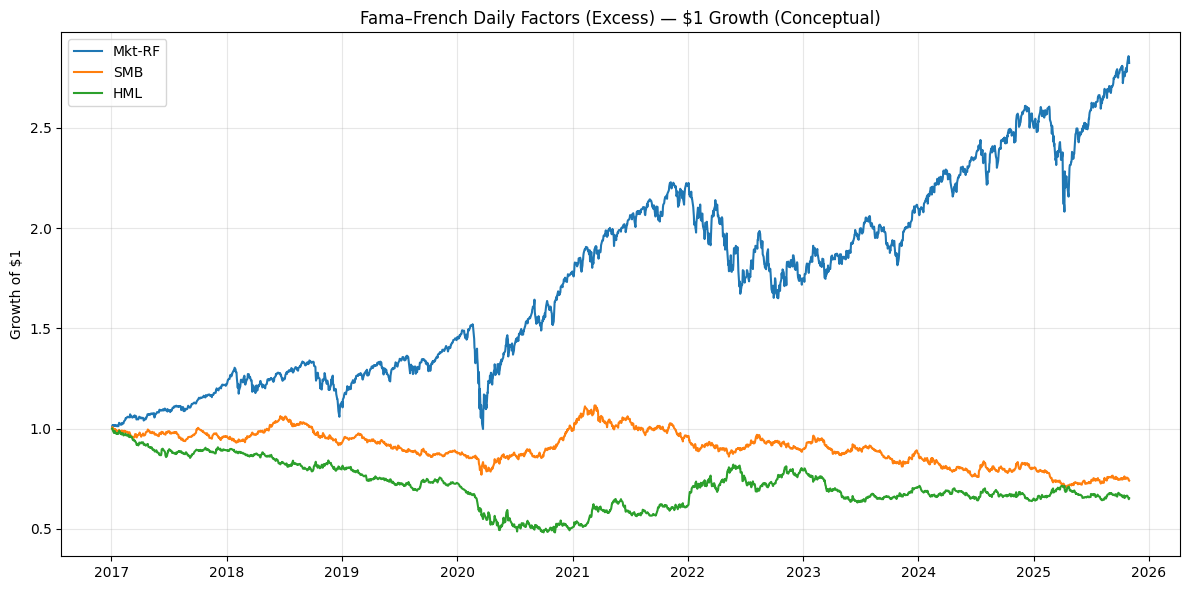

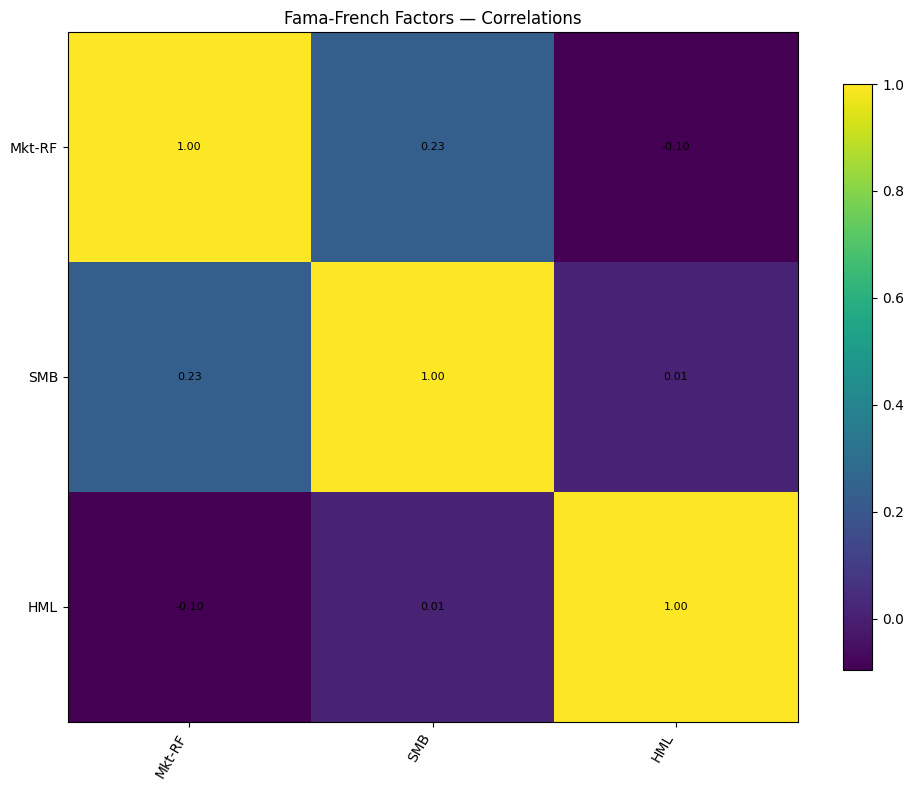

In [37]:
# FF factor behavior
ff_excess = ff[["Mkt-RF", "SMB", "HML"]].dropna()
fig, ax = plt.subplots(figsize=(12, 6))
for c in ff_excess.columns:
    ax.plot(cum_growth(ff_excess[c]), label=c)
ax.set_title("Fama–French Daily Factors (Excess) — $1 Growth (Conceptual)")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
ax.legend()
plot_and_save(fig, "ff_factor_growth")

# Factor correlations
corr_heatmap(ff_excess, "Fama-French Factors — Correlations", "corr_heatmap_ff_factors")



=== FF 3-factor exposures (monthly rebalanced benchmarks) ===
                            alpha_ann  beta_mkt  beta_smb  beta_hml      R2  \
Series                                                                        
Equity_100                    -0.0174    0.9883   -0.1237    0.0207  0.9969   
70_30_Equity_AGG              -0.0141    0.6900   -0.0602   -0.0028  0.9793   
60_40_Equity_AGG              -0.0130    0.5925   -0.0405   -0.0101  0.9573   
60_30_10_Equity_AGG_REIT      -0.0177    0.6727   -0.0358    0.0196  0.9569   
Diversified_40_30_10_10_10    -0.0015    0.5126   -0.0065    0.0319  0.8657   
PutWrite_100                  -0.0300    0.6396   -0.1595    0.0294  0.8023   
AllWeather_like               -0.0035    0.3810    0.0466   -0.0254  0.5941   
Treasury_Barbell_IEF_TLT      -0.0008   -0.1154    0.1165   -0.1732  0.0921   

                            t_alpha     t_mkt    t_smb   t_hml  
Series                                                          
Equity_100      

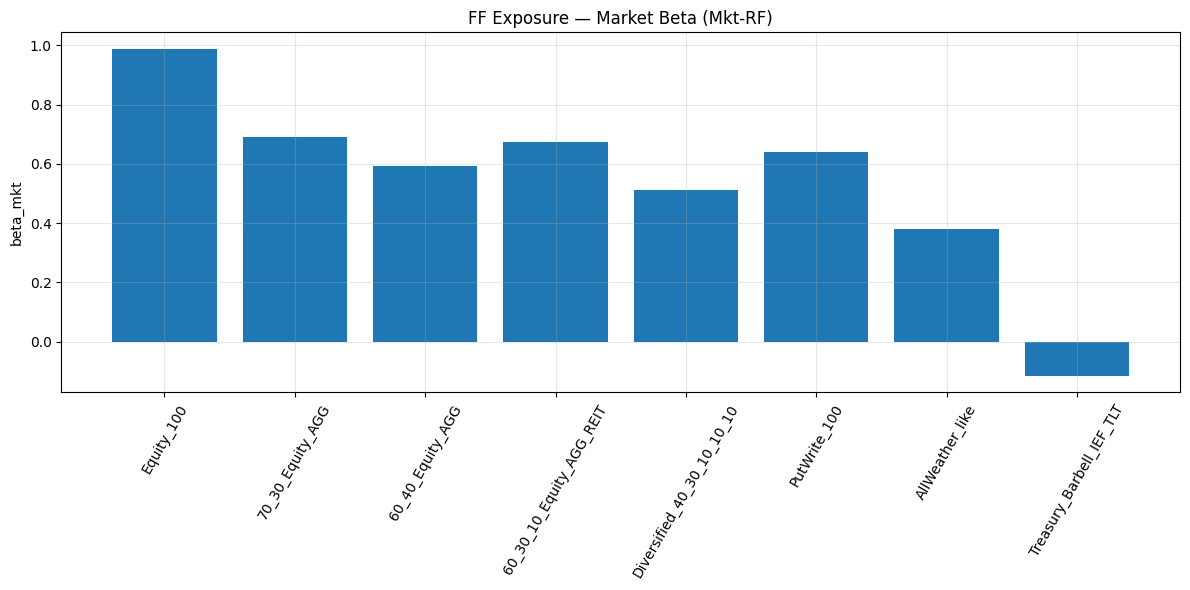

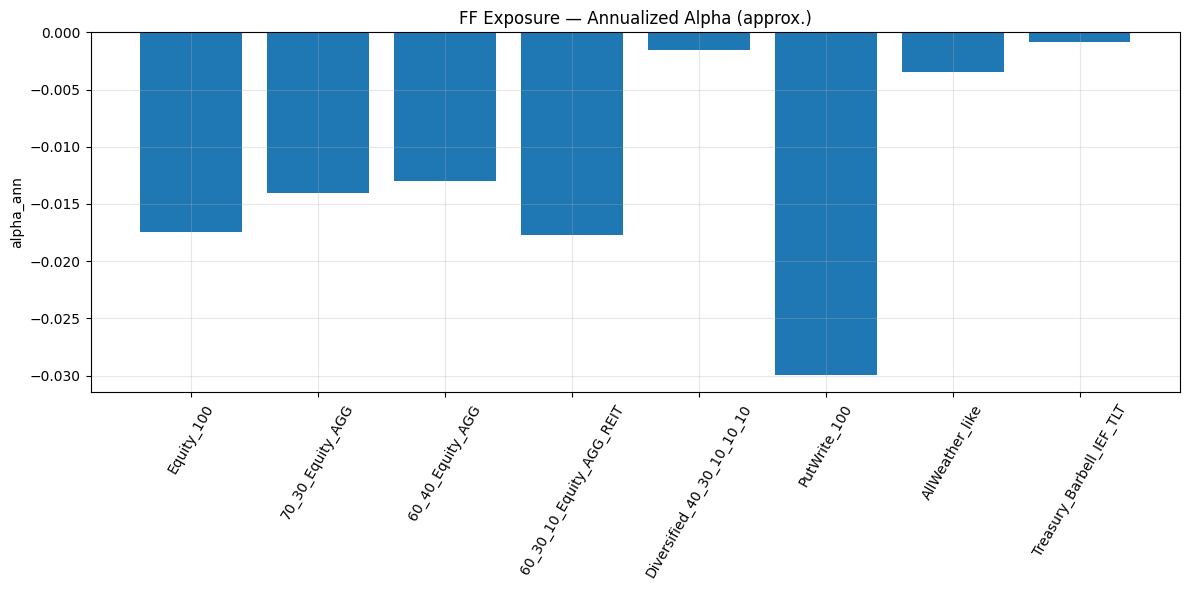

In [38]:
# FF regressions exposures for each benchmark
# Use monthly-rebalanced portfolios as the 
ff_aligned = ff.loc[port_rets_m.index].dropna()
reg_rows = []

for c in port_rets_m.columns:
    r = port_rets_m[c].dropna()
    dfc = pd.concat([r, ff_aligned], axis=1).dropna()
    if dfc.shape[0] < 200:
        continue

    # Excess portfolio return
    ex = dfc[c] - dfc["RF"]

    m = ff_regression(ex, dfc[FF_COLS])

    alpha_daily = m.params.get("const", np.nan)
    alpha_ann = alpha_daily * TRADING_DAYS  # small daily alpha approximation

    reg_rows.append({
        "Series": c,
        "alpha_ann": alpha_ann,
        "beta_mkt": m.params.get("Mkt-RF", np.nan),
        "beta_smb": m.params.get("SMB", np.nan),
        "beta_hml": m.params.get("HML", np.nan),
        "R2": m.rsquared,
        "t_alpha": m.tvalues.get("const", np.nan),
        "t_mkt": m.tvalues.get("Mkt-RF", np.nan),
        "t_smb": m.tvalues.get("SMB", np.nan),
        "t_hml": m.tvalues.get("HML", np.nan),
    })

reg_tbl = pd.DataFrame(reg_rows).set_index("Series").sort_values("R2", ascending=False)
reg_tbl.to_csv(os.path.join(TABLE_DIR, "ff_3factor_exposures_monthlyrebalanced.csv"))

print("\n=== FF 3-factor exposures (monthly rebalanced benchmarks) ===")
print(reg_tbl.round(4))

# Plot betas
if not reg_tbl.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(reg_tbl.index, reg_tbl["beta_mkt"])
    ax.set_title("FF Exposure — Market Beta (Mkt-RF)")
    ax.set_ylabel("beta_mkt")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=60)
    plot_and_save(fig, "ff_beta_market_bar")

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(reg_tbl.index, reg_tbl["alpha_ann"])
    ax.set_title("FF Exposure — Annualized Alpha (approx.)")
    ax.set_ylabel("alpha_ann")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="x", rotation=60)
    plot_and_save(fig, "ff_alpha_ann_bar")

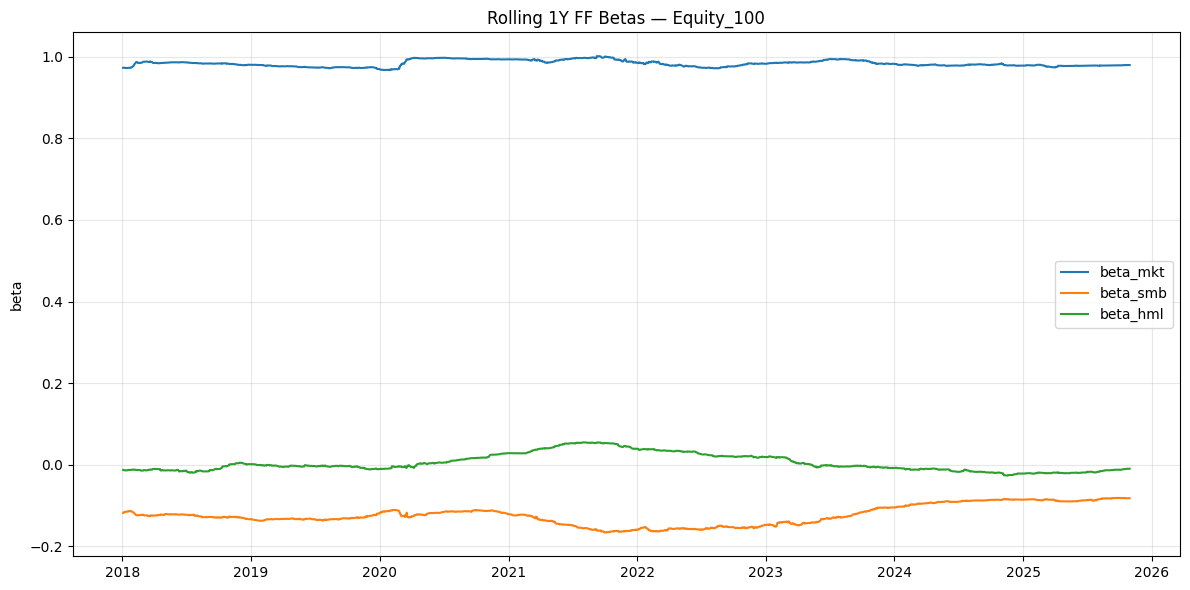

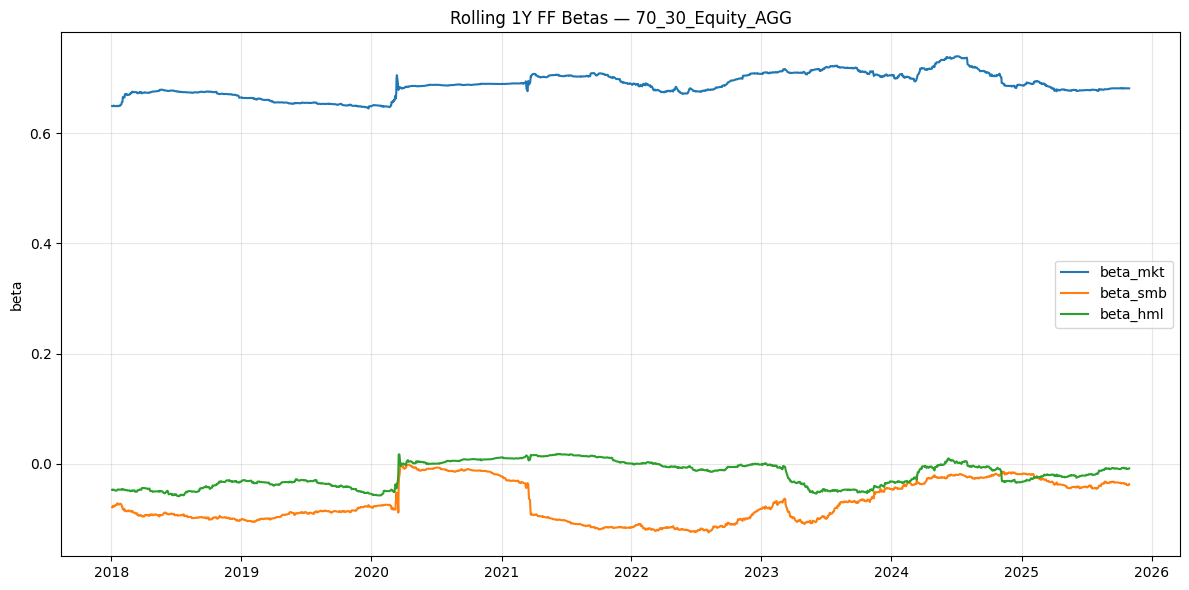

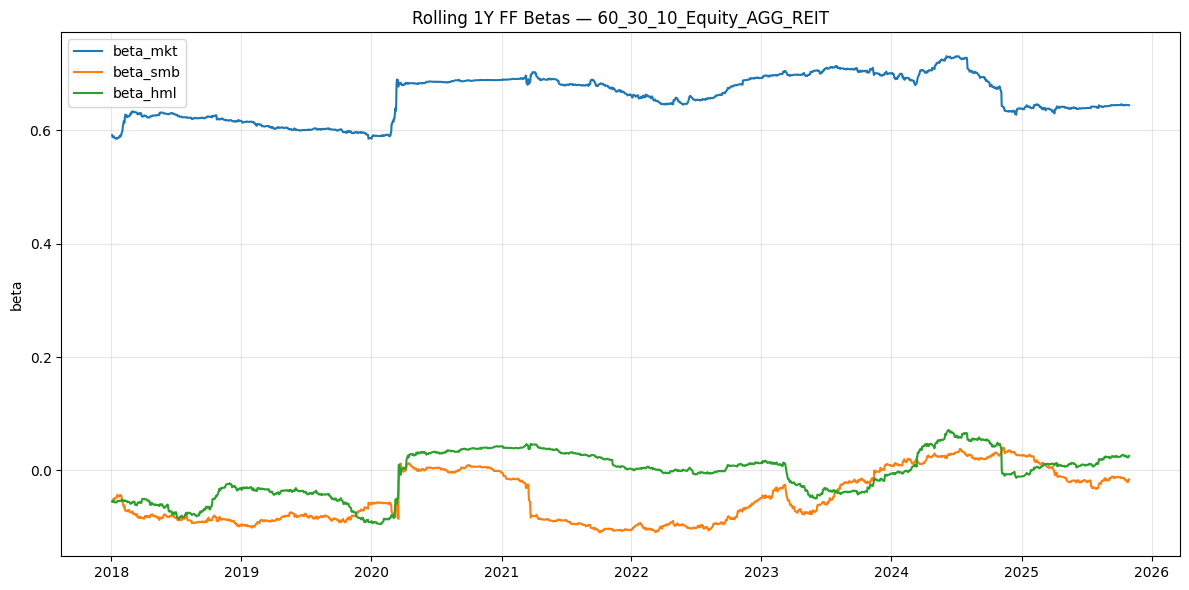

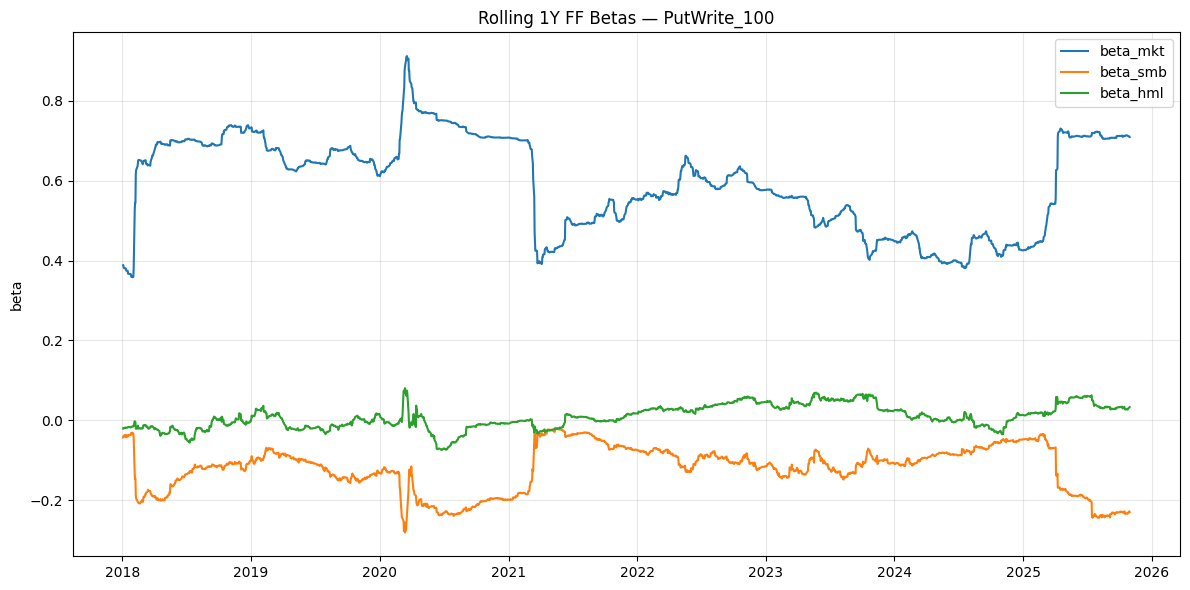

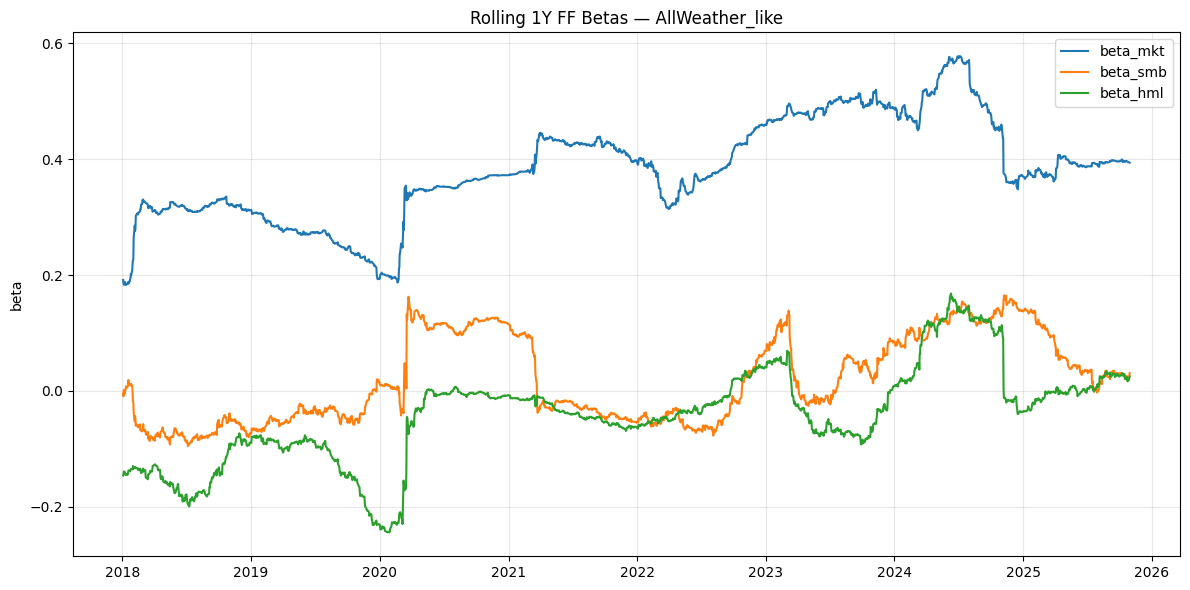

In [39]:
# Rolling FF betas for the main benchmark set
headline = ["Equity_100", "70_30_Equity_AGG", "60_30_10_Equity_AGG_REIT", "PutWrite_100", "AllWeather_like"]
headline = [h for h in headline if h in port_rets_m.columns]

for c in headline:
    dfc = pd.concat([port_rets_m[c], ff_aligned], axis=1).dropna()
    if dfc.shape[0] < ROLL_1Y + 50:
        continue

    ex = dfc[c] - dfc["RF"]
    betas = rolling_ff_betas(ex, dfc[FF_COLS], window=ROLL_1Y)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(betas["beta_mkt"], label="beta_mkt")
    ax.plot(betas["beta_smb"], label="beta_smb")
    ax.plot(betas["beta_hml"], label="beta_hml")
    ax.set_title(f"Rolling 1Y FF Betas — {c}")
    ax.set_ylabel("beta")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plot_and_save(fig, f"rolling_ff_betas_{c}")


Worst equity drawdown episodes (Equity_100):
         peak      trough     recover  equity_dd
0  2020-02-19  2020-03-23  2020-08-18  -0.339250
1  2022-01-03  2022-10-12  2024-01-19  -0.254251
2  2018-09-20  2018-12-24  2019-04-23  -0.197782
3  2025-02-19  2025-04-08  2025-06-27  -0.189022
4  2018-01-26  2018-02-08  2018-08-24  -0.101595


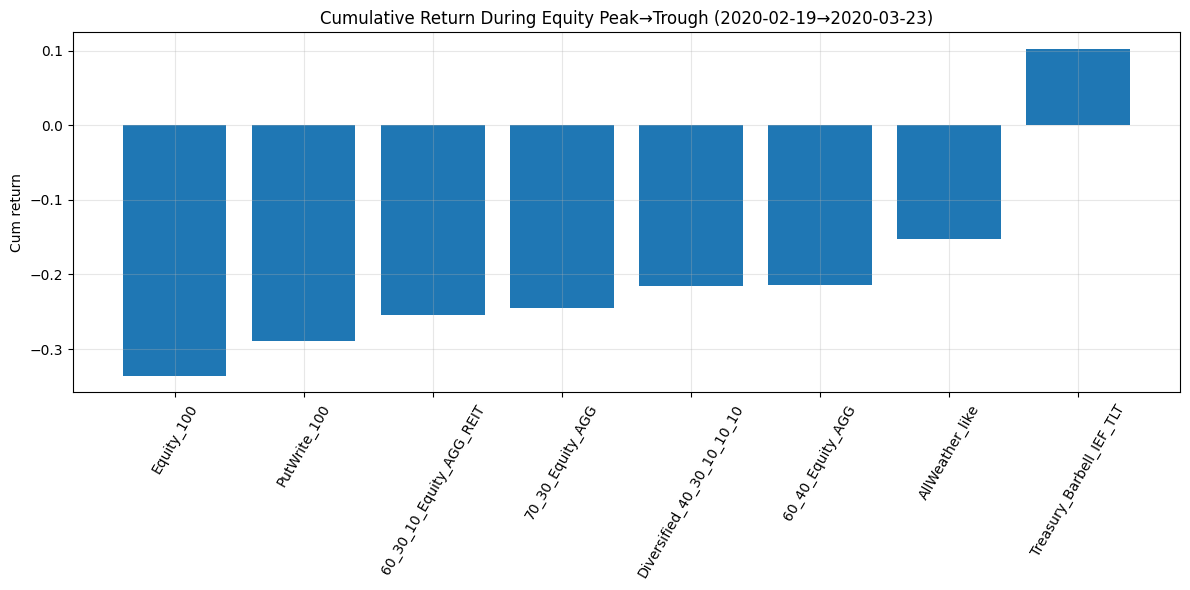

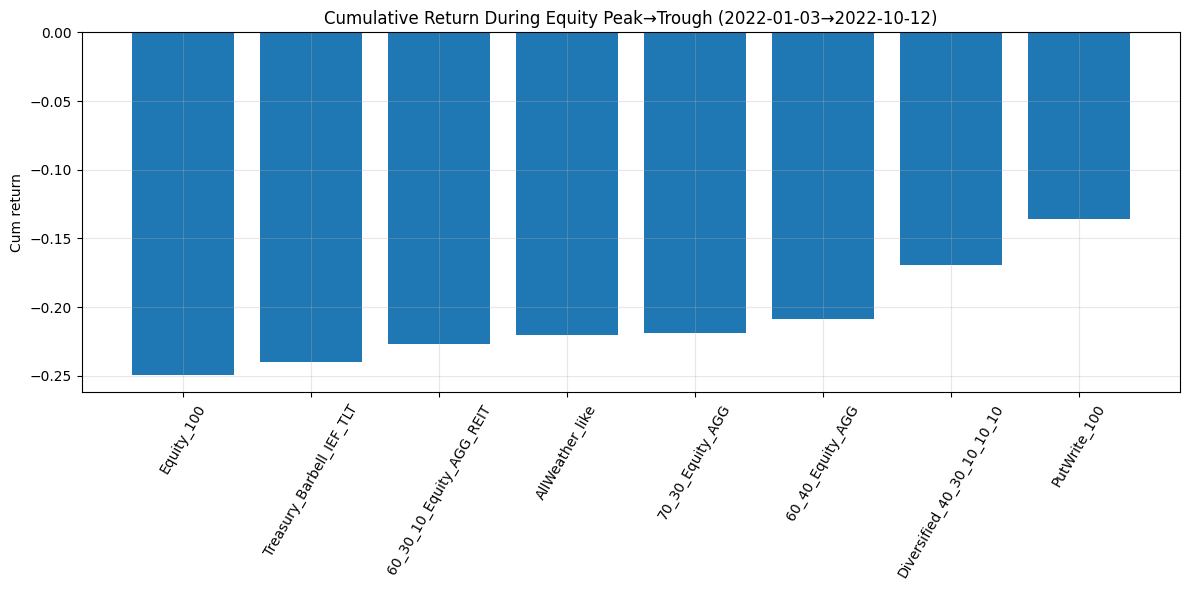

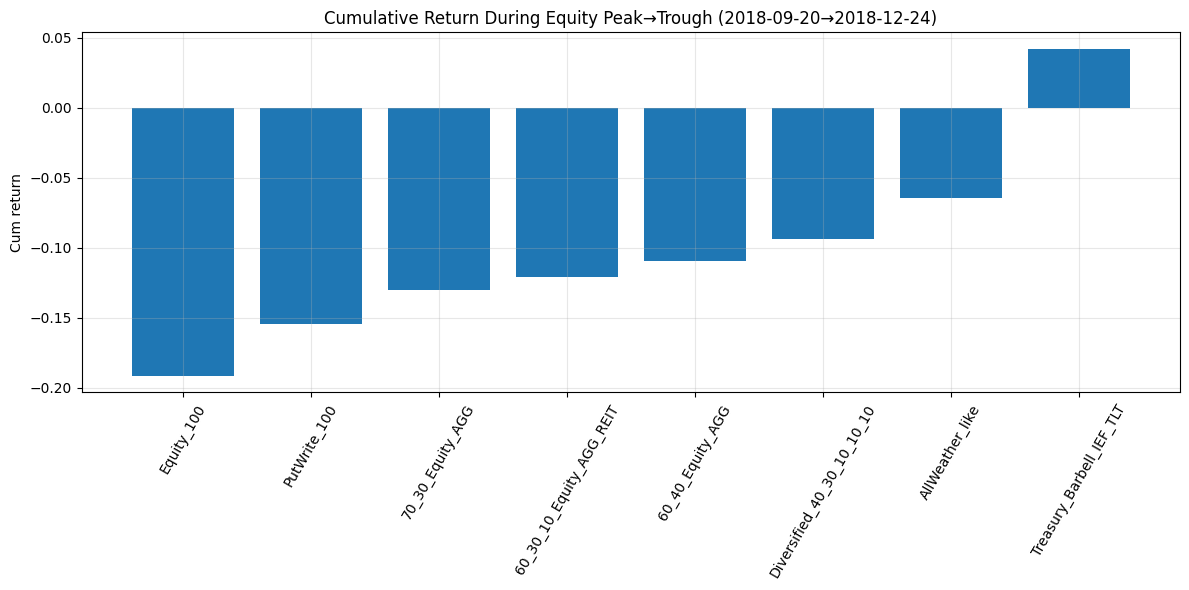

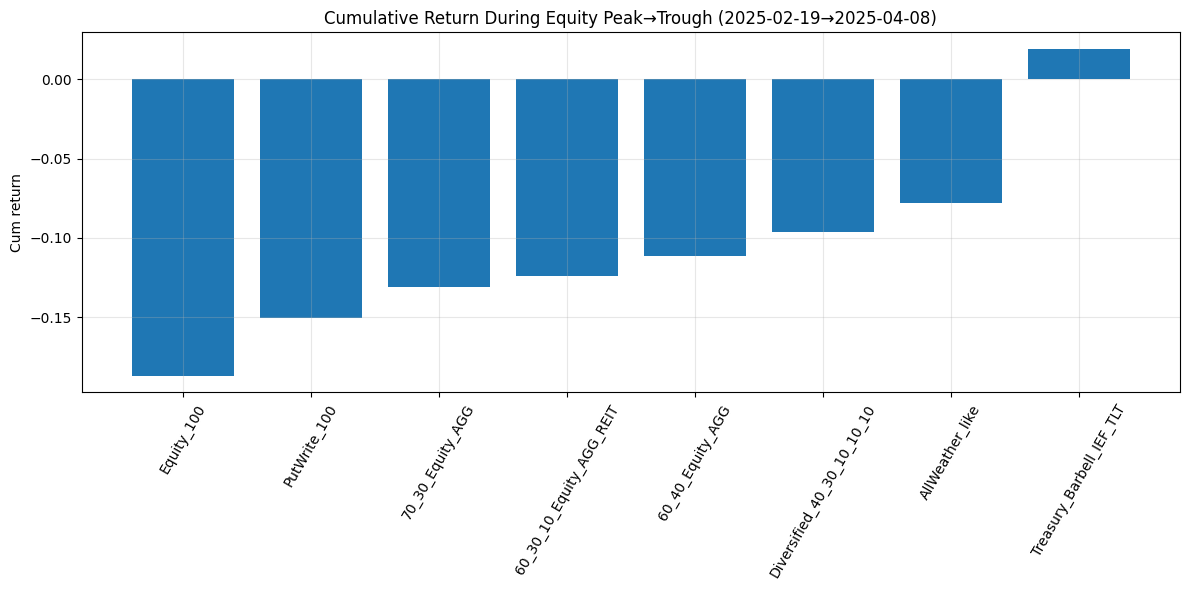

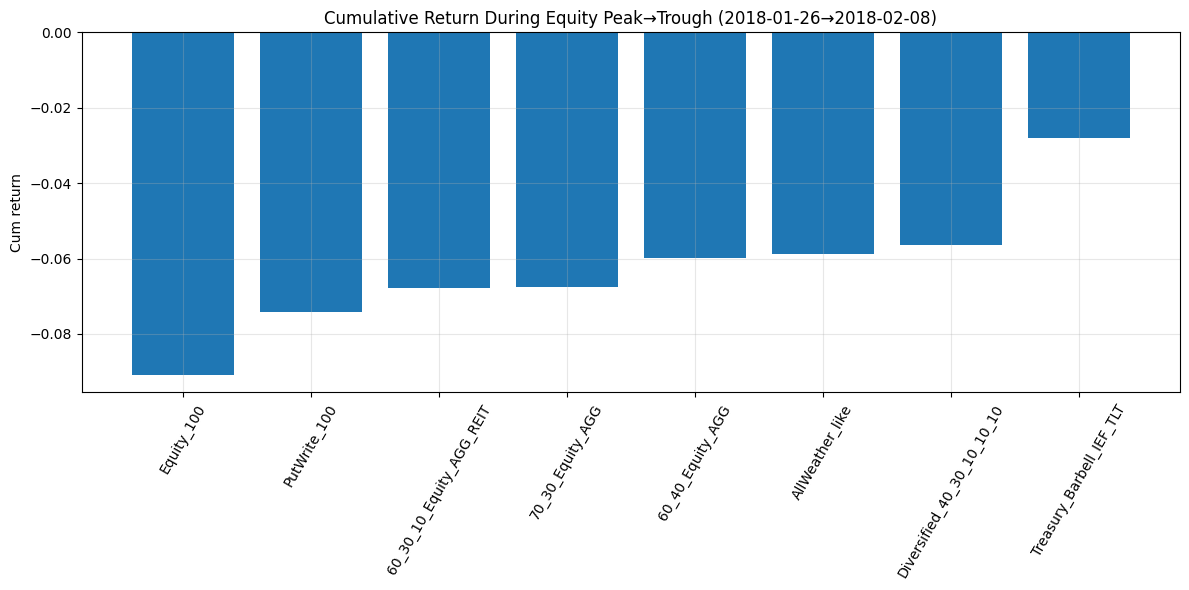

In [40]:
# stress windows show how benchmarks behave in the worst equity drawdowns
equity_series = port_rets_m["Equity_100"].dropna() if "Equity_100" in port_rets_m.columns else None
if equity_series is not None and not equity_series.empty:
    episodes = worst_drawdown_windows(equity_series, top_n=5)
    rows = []
    for peak_dt, trough_dt, recover_dt, dd in episodes:
        rows.append({
            "peak": peak_dt.date(),
            "trough": trough_dt.date(),
            "recover": recover_dt.date(),
            "equity_dd": dd
        })
    stress_tbl = pd.DataFrame(rows)
    stress_tbl.to_csv(os.path.join(TABLE_DIR, "worst_equity_drawdown_episodes.csv"), index=False)
    print("\nWorst equity drawdown episodes (Equity_100):")
    print(stress_tbl)

    # Portfolio returns in those windows 
    if episodes:
        stress_perf = []
        for peak_dt, trough_dt, _, dd in episodes:
            sl = slice(peak_dt, trough_dt)
            for c in port_rets_m.columns:
                rr = port_rets_m[c].loc[sl].dropna()
                if rr.empty:
                    continue
                cum = (1 + rr).prod() - 1
                stress_perf.append({"episode": f"{peak_dt.date()}→{trough_dt.date()}", "series": c, "cum_return": cum})
        stress_perf = pd.DataFrame(stress_perf)
        stress_perf.to_csv(os.path.join(TABLE_DIR, "portfolio_returns_in_worst_equity_dd_windows.csv"), index=False)

        # Plot each episode as a bar chart
        for ep in stress_perf["episode"].unique():
            d = stress_perf[stress_perf["episode"] == ep].sort_values("cum_return")
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.bar(d["series"], d["cum_return"])
            ax.set_title(f"Cumulative Return During Equity Peak→Trough ({ep})")
            ax.set_ylabel("Cum return")
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis="x", rotation=60)
            plot_and_save(fig, f"stress_episode_{ep}".replace("→", "_to_").replace(":", ""))